In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture

import os
import sys

In [21]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('stl-10', 128, False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
cifar_aug = transforms.Compose([
    transforms.RandomResizedCrop(size=[96, 96], scale=(0.2, 1.0), ratio=(0.75, 1.3333)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
])

def augment(x, transformations):
    '''
    x: tensor of shape (Batch, 3, 32, 32)
    transformations: list of transformations
    '''
    x = x.clone()
    for i in range(x.shape[0]):
        x[i] = transformations(x[i])
    return x

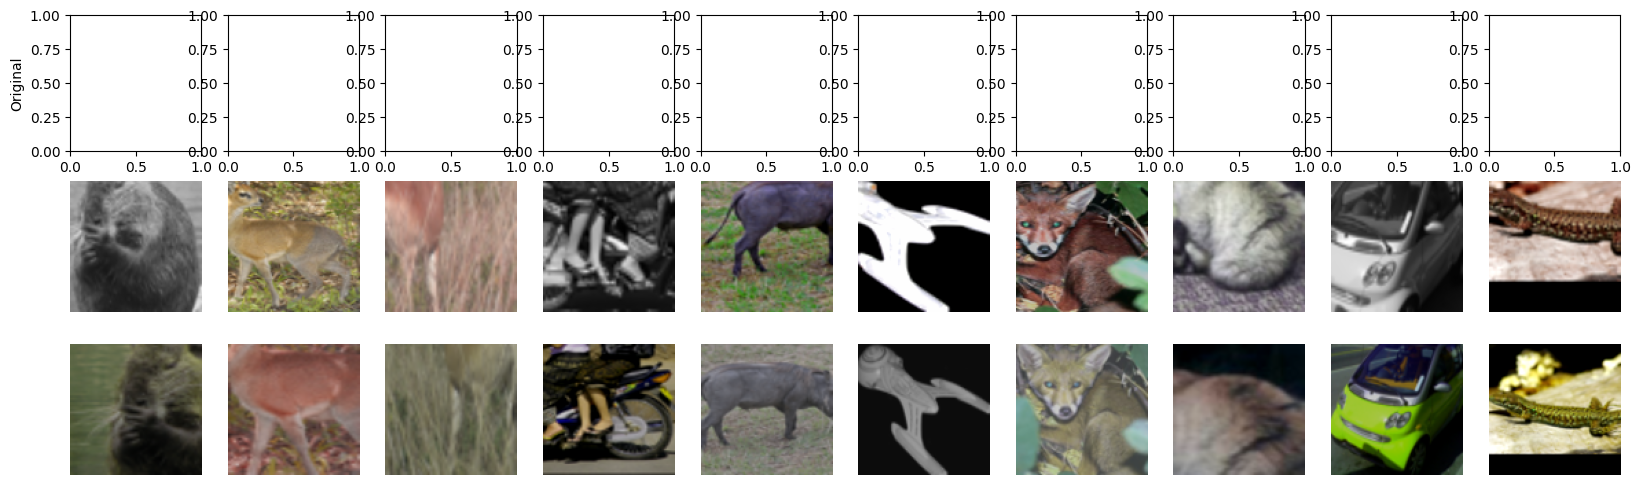

In [23]:
for i, batch in enumerate(train_loader):
    # x_aug1 = augment(x, cifar_aug)
    # x_aug2 = augment(x, cifar_aug)

    x_aug1, x_aug2 = batch

    # display the first 10 images of x, x_aug1, x_aug2
    fig, ax = plt.subplots(3, 10, figsize=(20, 6))
    for j in range(10):
        # ax[0, j].imshow(x[j].permute(1, 2, 0).cpu().numpy())
        # ax[0, j].axis('off')
        ax[1, j].imshow(x_aug1[j].permute(1, 2, 0).cpu().numpy())
        ax[1, j].axis('off')
        ax[2, j].imshow(x_aug2[j].permute(1, 2, 0).cpu().numpy())
        ax[2, j].axis('off')
    ax[0, 0].set_ylabel('Original')
    ax[1, 0].set_ylabel('Aug1')
    ax[2, 0].set_ylabel('Aug2')
    plt.show()
    break

In [10]:
def contrastive_loss(similarity_matrix, temperature=0.5):
    """
    Compute the contrastive loss given the similarity matrix.
    """
    # Get the number of samples
    batch_size_2n = similarity_matrix.shape[0]
    n = batch_size_2n // 2
    device = similarity_matrix.device

    # Scale similarities by temperature
    logits = similarity_matrix / temperature

    # Create labels: positive pair is (i, i+N) and (i+N, i)
    # For row i (0 <= i < N), target is i+N
    # For row i+N (0 <= i < N), target is i
    labels = torch.cat([torch.arange(n) + n, torch.arange(n)], dim=0)
    labels = labels.to(device) # Ensure labels are on the same device as logits

    # --- Masking out self-similarity ---
    # Create a mask to prevent examples from being compared with themselves.
    # This is crucial because exp(sim(i,i)/temp) should not be in the denominator.
    # F.cross_entropy implicitly handles the softmax and log calculation.
    # By setting the diagonal (self-similarity) logits to a very low number (-inf),
    # we ensure they don't contribute to the denominator sum in the softmax.
    mask = torch.eye(batch_size_2n, dtype=torch.bool).to(device)
    logits = logits.masked_fill(mask, -float('inf')) # Mask diagonal

    # --- Compute Cross-Entropy Loss ---
    # F.cross_entropy computes: -log(softmax(logits))[label]
    # which is equivalent to the NT-Xent loss formula when averaged over the batch.
    # Logits shape: (batch_size_2n, batch_size_2n) -> (Current Sample, All Other Samples)
    # Labels shape: (batch_size_2n) -> Index of the positive sample for each current sample
    loss = F.cross_entropy(logits, labels, reduction='mean')

    return loss

In [11]:
# test
similarity_matrix = torch.randn(4, 4)
loss = contrastive_loss(similarity_matrix)
print(f"Contrastive Loss: {loss.item()}")

Contrastive Loss: 0.5216601490974426
